<a href="https://colab.research.google.com/github/mounikaduddukuri/S12/blob/master/Assignment12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h3>Install Albumentations and Apex libraries</h3>**

In [0]:
%matplotlib inline

In [0]:
!pip install -U git+https://github.com/albu/albumentations
!pip install --no-cache-dir git+https://github.com/NVIDIA/apex

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nf6s0_gr
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nf6s0_gr
     |████████████████████████████████| 634kB 4.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=73b75bd891d3a6b5c1f6505c228ad143776e5389e77b8d8467032704fe20a636
  Stored in directory: /tmp/pip-ephem-wheel-cache-h62gwxoo/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=94d2d677561171d530edebb6ca923c978c799b89c6940b8e4a6a48b97a2eed4f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

**<h3>Mount Drive and unzip data<h3>**

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session12'
sys.path.append(folder)

**<h3>Import required files<h3>**

In [0]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import LR_Range_Test

In [0]:
!unzip -uq "/content/gdrive/My Drive/Session12/tiny-imagenet-200.zip" -d "/content/gdrive/My Drive/Session12/PATH_TO_OUTPUT"

In [0]:
!unzip -u "/content/gdrive/My Drive/Session12/tiny-imagenet-200.zip" -d "/content/gdrive/My Drive/Session12/imagenet"

Archive:  /content/gdrive/My Drive/Session12/tiny-imagenet-200.zip


In [0]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 31.84 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [0]:
import time
import scipy.ndimage as nd
import numpy as np
import imageio
path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [imageio.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), pilmode='RGB') for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(imageio.imread( path + 'val/images/{}'.format(img_name) ,pilmode='RGB'))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 39.62365388870239 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [0]:
#splitting the data and finding the mean to normalise it
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(train_data,train_labels, test_size = 0.3, random_state = 0)
mean_image = np.mean(xTrain, axis=0)
xTrain = xTrain.astype('float32')
xTrain -= mean_image
xTrain /= 128.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



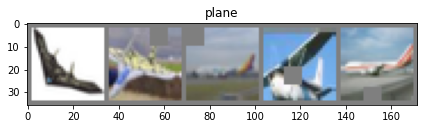

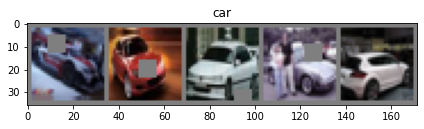

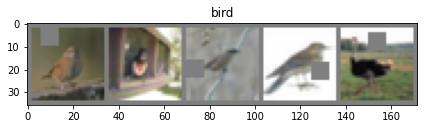

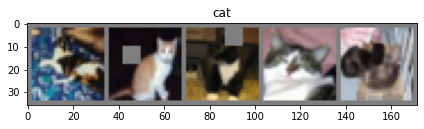

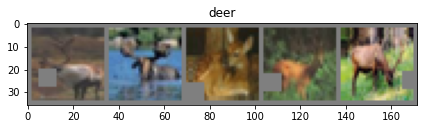

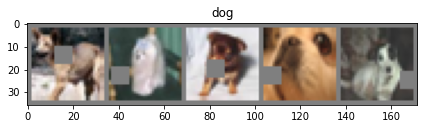

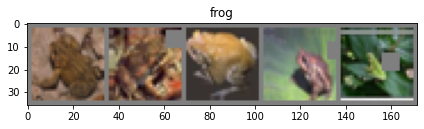

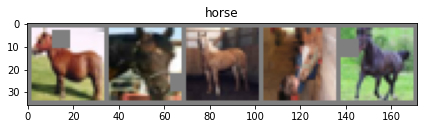

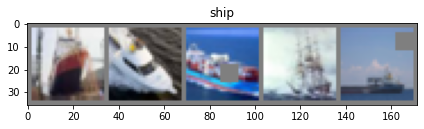

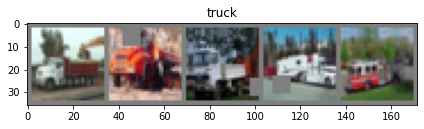

In [0]:
show_images.show_random_images(trainloader, classes)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

**<h3>Code for Range Test on 10 epochs<h3>**

epoch = 1 Lr = 0.001  Loss=1.3575565814971924 Batch_id=97 Accuracy=39.69: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
epoch = 2 Lr = 0.0029  Loss=1.2298139333724976 Batch_id=97 Accuracy=46.87: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
epoch = 3 Lr = 0.0048  Loss=1.204017996788025 Batch_id=97 Accuracy=44.06: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]
epoch = 4 Lr = 0.006699999999999999  Loss=1.104041576385498 Batch_id=97 Accuracy=44.21: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
epoch = 5 Lr = 0.0086  Loss=1.2137959003448486 Batch_id=97 Accuracy=39.98: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
epoch = 6 Lr = 0.0105  Loss=1.6062517166137695 Batch_id=97 Accuracy=27.04: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
epoch = 7 Lr = 0.012400000000000001  Loss=1.7301565408706665 Batch_id=97 Accuracy=23.31: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]
epoch = 8 Lr = 0.014300000000000002  Loss=2.5102179050445557 Batch_id=97 Accuracy=18.80: 100%|██████████| 98/98 [0

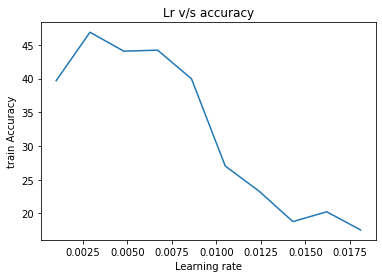

In [0]:
import torch.nn as nn
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.NLLLoss()
LR_Range_Test.LR_test(max_lr, min_lr,device,epoch,resnet,criterion,trainloader,momemtum = 0.9,weight_decay=0.00005, plot= True )

**<h3>OneCycleLR Policy<h3>**

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

optimizer = optim.SGD(resnet.parameters(), lr=0.01,momentum=0.9,weight_decay=0.00005 ) 
criterion = nn.NLLLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=1, pct_start=0.2083, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

**<h3>Train for 24 epochs with 90% accuracy<h3>**

In [0]:
train_test.training(resnet,device,trainloader,testloader,optimizer,criterion,24,scheduler)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.00125


Loss=1.2663075923919678 Batch_id=97 Accuracy=41.54: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5453/10000 (54.53%)

EPOCH: 2 LR: 0.004063062612522505


Loss=0.9672345519065857 Batch_id=97 Accuracy=59.32: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6675/10000 (66.75%)

EPOCH: 3 LR: 0.00687612522504501


Loss=0.7565451860427856 Batch_id=97 Accuracy=68.38: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7167/10000 (71.67%)

EPOCH: 4 LR: 0.009689187837567514


Loss=0.7140982747077942 Batch_id=97 Accuracy=74.54: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7297/10000 (72.97%)

EPOCH: 5 LR: 0.012499526335733233


Loss=0.5051943063735962 Batch_id=97 Accuracy=76.04: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7715/10000 (77.15%)

EPOCH: 6 LR: 0.01190744600227359


Loss=0.5189529657363892 Batch_id=97 Accuracy=81.14: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8268/10000 (82.68%)

EPOCH: 7 LR: 0.011315365668813946


Loss=0.43973278999328613 Batch_id=97 Accuracy=84.07: 100%|██████████| 98/98 [00:24<00:00,  3.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 8051/10000 (80.51%)

EPOCH: 8 LR: 0.0107232853353543


Loss=0.4599342942237854 Batch_id=97 Accuracy=86.22: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8321/10000 (83.21%)

EPOCH: 9 LR: 0.010131205001894657


Loss=0.3869568407535553 Batch_id=97 Accuracy=87.99: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8362/10000 (83.62%)

EPOCH: 10 LR: 0.009539124668435013


Loss=0.2361798733472824 Batch_id=97 Accuracy=89.65: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8682/10000 (86.82%)

EPOCH: 11 LR: 0.00894704433497537


Loss=0.24744002521038055 Batch_id=97 Accuracy=91.35: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8622/10000 (86.22%)

EPOCH: 12 LR: 0.008354964001515724


Loss=0.3179660439491272 Batch_id=97 Accuracy=92.49: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8661/10000 (86.61%)

EPOCH: 13 LR: 0.007762883668056082


Loss=0.21310994029045105 Batch_id=97 Accuracy=93.63: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8796/10000 (87.96%)

EPOCH: 14 LR: 0.007170803334596438


Loss=0.19175373017787933 Batch_id=97 Accuracy=94.47: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8673/10000 (86.73%)

EPOCH: 15 LR: 0.006578723001136794


Loss=0.13565455377101898 Batch_id=97 Accuracy=95.19: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8693/10000 (86.93%)

EPOCH: 16 LR: 0.00598664266767715


Loss=0.09635470062494278 Batch_id=97 Accuracy=95.92: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8865/10000 (88.65%)

EPOCH: 17 LR: 0.0053945623342175055


Loss=0.10755234956741333 Batch_id=97 Accuracy=96.34: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8789/10000 (87.89%)

EPOCH: 18 LR: 0.004802482000757862


Loss=0.10739555954933167 Batch_id=97 Accuracy=97.02: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8904/10000 (89.04%)

EPOCH: 19 LR: 0.0042104016672982175


Loss=0.07796990126371384 Batch_id=97 Accuracy=97.39: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8956/10000 (89.56%)

EPOCH: 20 LR: 0.003618321333838574


Loss=0.058023519814014435 Batch_id=97 Accuracy=97.74: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8975/10000 (89.75%)

EPOCH: 21 LR: 0.0030262410003789302


Loss=0.058880362659692764 Batch_id=97 Accuracy=98.03: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8968/10000 (89.68%)

EPOCH: 22 LR: 0.0024341606669192866


Loss=0.0548299141228199 Batch_id=97 Accuracy=98.26: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9001/10000 (90.01%)

EPOCH: 23 LR: 0.001842080333459643


Loss=0.04283275082707405 Batch_id=97 Accuracy=98.42: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9037/10000 (90.37%)

EPOCH: 24 LR: 0.0012499999999999994


Loss=0.07504075765609741 Batch_id=97 Accuracy=98.64: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0007, Accuracy: 9017/10000 (90.17%)



**<h3>Plot for LR vs epochs</h3>**

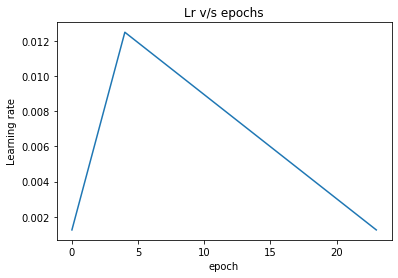

In [0]:
plt.plot(train_test.LR_list)
plt.ylabel('Learning rate')
plt.xlabel("epoch")
plt.title("Lr v/s epochs")
plt.show()

In [0]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 90.170 %


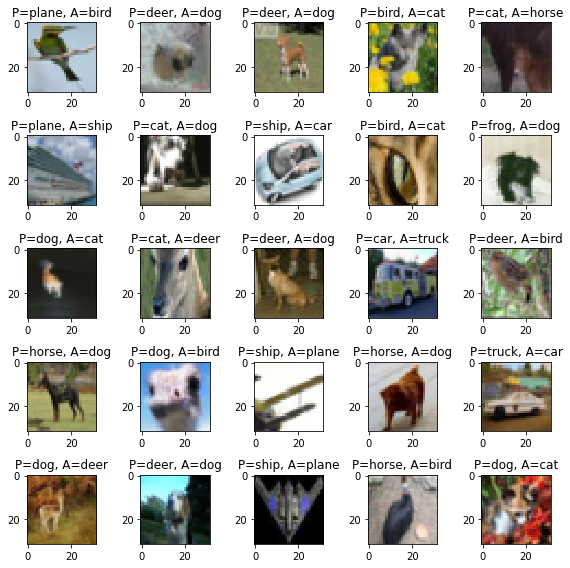

In [0]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [0]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 100 %
Accuracy of   car : 90 %
Accuracy of  bird : 100 %
Accuracy of   cat : 87 %
Accuracy of  deer : 83 %
Accuracy of   dog : 100 %
Accuracy of  frog : 85 %
Accuracy of horse : 75 %
Accuracy of  ship : 92 %
Accuracy of truck : 100 %


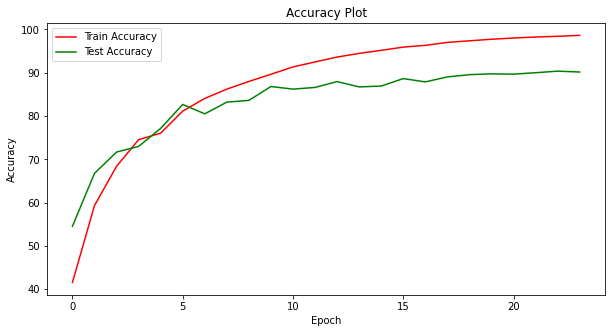

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(train_test.train_acc_epoch_end,color = 'r',label="Train Accuracy")
ax.plot(train_test.test_acc,color = 'g',label="Test Accuracy")
ax.set(title="Accuracy Plot", xlabel="Epoch", ylabel="Accuracy")
ax.legend()
plt.show()

**<h3>GradCam for misclassified for 4 layers</h3>**

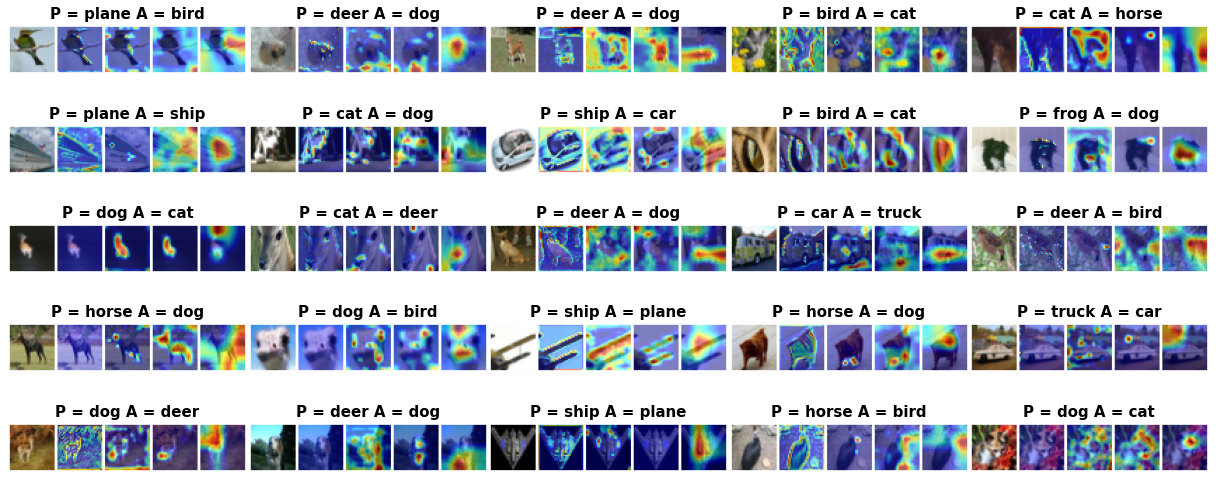

In [0]:
layers = [resnet.preplayer,resnet.ResBlock_R1,resnet.layer2,resnet.ResBlock_R2]
GradCam.GradCAM.GradCamPlot(misclassified_images,resnet,classes,layers,Figsize = (17,8),subplotx1 = 5, subplotx2 = 5)